In [20]:
import os
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC, SVC
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [3]:
# --- Configuration ---
CSV_PATH = "miRNA_wide_format.csv" 
ID_COL = "file_id"
LABEL_COL = "cancer_type"

TOP_PCT = 0.05
TEST_SIZE = 0.2
RANDOM_STATE = 42

N_ESTIMATORS = 400
MAX_DEPTH = None
N_JOBS = -1

In [4]:
BASE_DIR = "data/data"

cancer_types = [
    "Breast Invasive Carcinoma",
    "Kidney Renal Clear Cell Carcinoma",
    "Lung Adenocarcinoma",
    "Lung Squamous Cell Carcinoma",
    "Pancreatic Adenocarcinoma",
    "Uveal Melanoma"
]

In [5]:
# empty list to store each file's data
all_data = []

for cancer in cancer_types:
    cancer_dir = os.path.join(BASE_DIR, cancer)
    # Walk through files in the folder
    for root, _, files in os.walk(cancer_dir):
        for file in files:
            if file.endswith(".mirbase21.mirnas.quantification.txt"):
                file_path = os.path.join(root, file)
                df = pd.read_csv(file_path, sep="\t")
                    # choose the columns we need
                df = df[["miRNA_ID", "reads_per_million_miRNA_mapped"]]
                    # add a new column for the cancer type
                df["cancer_type"] = cancer
                    # aad the file name or ID to trace the files 
                df["file_id"] = os.path.basename(root)
                all_data.append(df)

# Combine data
combined_df = pd.concat(all_data, ignore_index=True)  
print(f"Total rows loaded: {len(combined_df)}")
print(combined_df.groupby("cancer_type")["file_id"].nunique()) #making sure it has the correct amount

Total rows loaded: 5445495
cancer_type
Breast Invasive Carcinoma            1096
Kidney Renal Clear Cell Carcinoma     544
Lung Adenocarcinoma                   519
Lung Squamous Cell Carcinoma          478
Pancreatic Adenocarcinoma             178
Uveal Melanoma                         80
Name: file_id, dtype: int64


In [7]:
# combined_df must have: file_id, cancer_type, miRNA_ID, reads_per_million_miRNA_mapped

# Make a samples × miRNA matrix (values = reads_per_million_miRNA_mapped)
wide = (
    combined_df
    .pivot_table(
        index=["file_id", "cancer_type"],
        columns="miRNA_ID",
        values="reads_per_million_miRNA_mapped",
        aggfunc="sum"   # or 'mean' if you prefer; sum is fine if no dups
    )
)

# Put NaNs to 0 and ensure numeric
wide = wide.fillna(0.0).astype(float)

# (optional) sort columns for consistency
wide = wide.sort_index(axis=1)

# Split back into X (features) and y (labels)
wide_df = wide.reset_index()                       # bring index columns back as regular cols
y = wide_df["cancer_type"].astype("category")      # labels
X_cont = wide_df.drop(columns=["file_id", "cancer_type"])  # continuous features

feature_cols = list(X_cont.columns)                # save for feature importances later

print(X_cont.shape, y.shape)
print("Classes:", list(y.cat.categories))


(2895, 1881) (2895,)
Classes: ['Breast Invasive Carcinoma', 'Kidney Renal Clear Cell Carcinoma', 'Lung Adenocarcinoma', 'Lung Squamous Cell Carcinoma', 'Pancreatic Adenocarcinoma', 'Uveal Melanoma']


In [8]:
def binarize_top_pct(X: pd.DataFrame, top_pct: float = 0.2) -> pd.DataFrame:
    X = X.copy()
    arr = X.values
    n_features = arr.shape[1]
    k = max(int(np.ceil(n_features * top_pct)), 1)
    # For each row, compute the cutoff and set top-k to 1 else 0
    bin_rows = []
    for row in arr:
        # Find the kth largest value (partial sort)
        if k >= n_features:
            thresh = np.min(row) - 1.0  # everything becomes 1
        else:
            # kth largest -> partition at n_features-k
            idx = np.argpartition(row, n_features - k)[n_features - k]
            thresh = row[idx]
        bin_row = (row >= thresh).astype(int)
        bin_rows.append(bin_row)
    bin_arr = np.vstack(bin_rows)
    return pd.DataFrame(bin_arr, columns=X.columns, index=X.index)

X_bin = binarize_top_pct(X_cont, TOP_PCT)
X_bin.head()

miRNA_ID,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,...,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,1,1


In [9]:
# train/test spilt
X_train, X_test, y_train, y_test = train_test_split(X_bin, y, test_size=0.2, random_state=42, stratify=y)

# scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
rf_bin = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)
rf_bin.fit(X_train_scaled, y_train)
print("Model trained.")

Model trained.


In [16]:
y_pred = rf_bin.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred)) 

Test Accuracy: 0.93

Classification Report:
                                   precision    recall  f1-score   support

        Breast Invasive Carcinoma       0.91      0.99      0.95       219
Kidney Renal Clear Cell Carcinoma       0.99      0.96      0.98       109
              Lung Adenocarcinoma       0.90      0.83      0.86       104
     Lung Squamous Cell Carcinoma       0.94      0.89      0.91        96
        Pancreatic Adenocarcinoma       0.97      0.91      0.94        35
                   Uveal Melanoma       1.00      1.00      1.00        16

                         accuracy                           0.93       579
                        macro avg       0.95      0.93      0.94       579
                     weighted avg       0.94      0.93      0.93       579



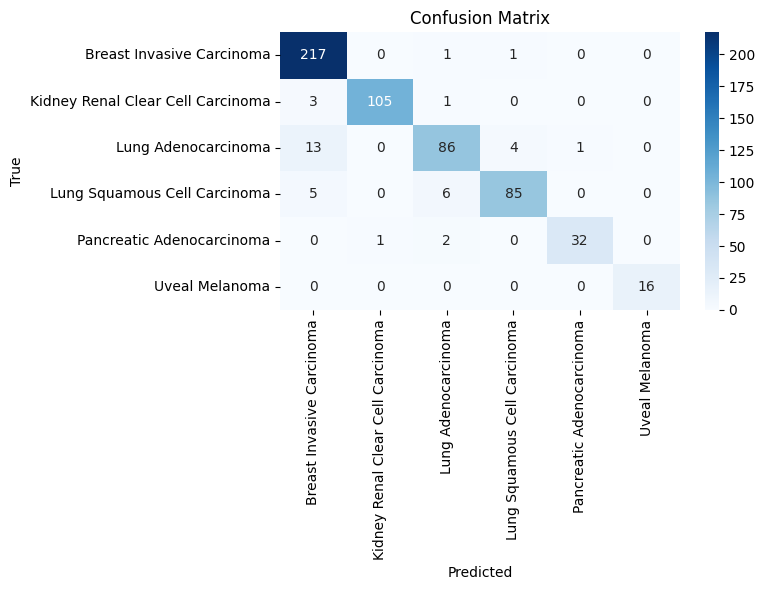

In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# build a robust, ordered label list (works for str/int/category)
labels = sorted(pd.unique(pd.concat(
    [pd.Series(y_train), pd.Series(y_test)], ignore_index=True
)))

cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(cm, index=labels, columns=labels),
            annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


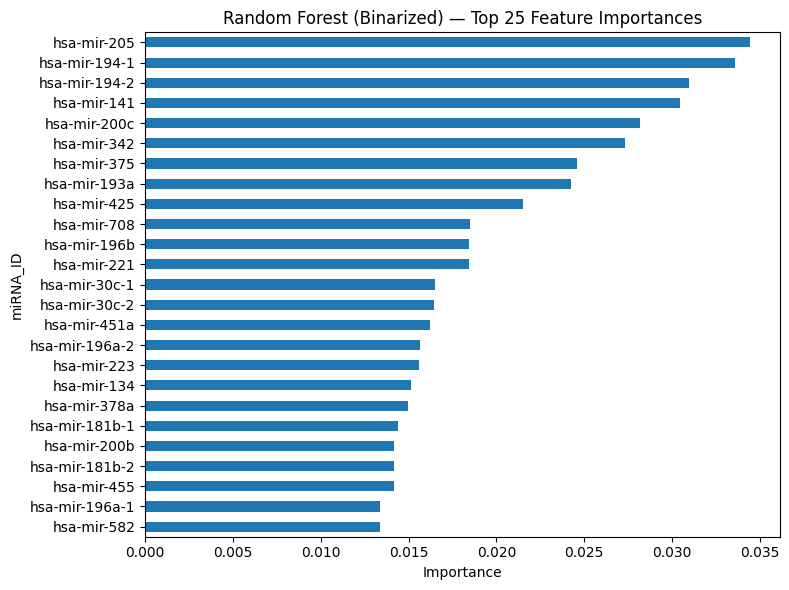

In [23]:
importances = pd.Series(rf_bin.feature_importances_, index=X_bin.columns)
top = importances.sort_values(ascending=False).head(25)

plt.figure(figsize=(8,6))
top[::-1].plot(kind='barh')
plt.title("Random Forest (Binarized) — Top 25 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()